In [1]:
%pylab inline
import collections

import glob
import numpy as np
import scipy as sp
import json
import datetime as dt
import pandas as pd
from pandas.io.json import json_normalize
from PIL import Image

import importlib
import os
from os.path import join
from pathlib import Path
from matplotlib.colors import rgb_to_hsv

import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (8,8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
if importlib.util.find_spec("keras") is not None:
    from keras.applications.vgg19 import VGG19
    from keras.preprocessing import image
    from keras.applications.vgg19 import preprocess_input, decode_predictions
    from keras.models import Model
    keras_flag = True
else:
    keras_flag = False

Using TensorFlow backend.


In [3]:
if keras_flag:
    vgg19_full = VGG19(weights='imagenet')
    vgg19_full.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
img_path = join("C:/Users/jfeng/InstagramKDE", "downtownknoxville", "67176823_1526936847447274_6783693613585655549_n.jpg")
if keras_flag:
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
else:
    img = imread(img_path)
    x = img.copy().astype(np.float32)
    x = np.expand_dims(x, axis=0)
    
x.shape

(1, 224, 224, 3)

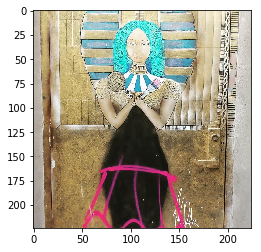

In [5]:
plt.imshow(img)

In [6]:
if keras_flag:
    y = vgg19_full.predict(x)
    print(y.shape)
    for pred in decode_predictions(y)[0]:
        print(pred)

(1, 1000)
40960/35363 [==================================] - 0s 3us/step
('n04532106', 'vestment', 0.2446537)
('n03026506', 'Christmas_stocking', 0.2442483)
('n03045698', 'cloak', 0.048258353)
('n03998194', 'prayer_rug', 0.025125094)
('n04525038', 'velvet', 0.02380068)


In [4]:
communities = ["utknoxville",
             "utkgeography",
             "tennessee",
             "knoxcounty",
             "downtownknoxville",
             "outdoors",
             "nourishknoxville",
             "sunrisesupermarket",
             "religion",
             "knoxvillepolice"]

In [5]:
# List of filepaths of all jpegs in a folder
for i in range(len(communities)):
    files = glob.glob("C:/Users/jfeng12/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/{}/*_n.jpg".format(communities[i]))
    files = pd.DataFrame(files, columns = ['Filepaths'])
    files.shape

    process_new = True

    if process_new:
        comm_img = np.zeros((files.shape[0], 224, 224, 3))

        for index, row in files.iterrows():
            img = image.load_img(row['Filepaths'], target_size=(224, 224))
            x = image.img_to_array(img)
            comm_img[index, :, :, :] = x
            if (index % 50) == 0:
                print("Done with {0:03d}".format(index))

        comm_img = preprocess_input(comm_img)
        comm_raw = vgg19_full.predict(comm_img, verbose=True)
        comm_vgg19 = decode_predictions(comm_raw, top=20)

    comm_vgg19 = np.array(comm_vgg19)
    print(comm_vgg19.shape)
    print(collections.Counter(comm_vgg19[:, 1, 1]).most_common(10))
    
    global imageCounter
    imageCounter = pd.DataFrame()
    imageCounter.append(collections.Counter(comm_vgg19[:,1,1]).most_common(10))
    imageCounter.to_csv("C:/Users/jfeng12/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/imagecategories.csv")

Done with 000
Done with 050
Done with 100
Done with 150
Done with 200
Done with 250
Done with 300
Done with 350
Done with 400
Done with 450
Done with 500
Done with 550
Done with 600
Done with 650
Done with 700
Done with 750
Done with 800
Done with 850
Done with 900
Done with 950
Done with 1000
Done with 1050
Done with 1100
Done with 1150
Done with 1200
Done with 1250
Done with 1300
Done with 1350
1370/1370 [==============================] - 157s 114ms/step
(1370, 20, 3)
[('web_site', 37), ('book_jacket', 36), ('stole', 35), ('envelope', 35), ('comic_book', 27), ('stage', 25), ('Band_Aid', 24), ('ballplayer', 23), ('wig', 20), ('jersey', 18)]
Done with 000
Done with 050
Done with 100
Done with 150
Done with 200
Done with 250
278/278 [==============================] - 31s 113ms/step
(278, 20, 3)
[('envelope', 33), ('book_jacket', 16), ('menu', 15), ('web_site', 13), ('home_theater', 7), ('comic_book', 5), ('mortarboard', 5), ('stole', 5), ('television', 5), ('academic_gown', 5)]
Done wit

In [14]:
    vgg_fc2 = Model(inputs=vgg19_full.input, outputs=vgg19_full.get_layer('fc2').output)
    y = vgg_fc2.predict(comm_img)
    comm_fc2 = vgg_fc2.predict(comm_img, verbose=True)
    print(comm_fc2.shape)
    
    plt.figure(figsize=(14, 14))

    dists = np.sum(np.abs(comm_fc2 - comm_fc2[1, :]), 1)
    idx = np.argsort(dists.flatten())[:12]

    for ind, i in enumerate(idx):
        try:
            plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
            plt.subplot(3, 4, ind + 1)

            img = imread(files.iloc[i]["Filepaths"])
            plt.imshow(img)
            plt.axis("off")
        except:
            pass

Done with 000
Done with 050
58/58 [==============================] - 6s 101ms/step
(58, 20, 3)
[('comic_book', 3), ('envelope', 3), ('sunglasses', 2), ('mask', 2), ('ice_cream', 2), ('miniskirt', 2), ('mitten', 2), ('wool', 2), ('theater_curtain', 1), ('military_uniform', 1)]
58/58 [==============================] - 6s 109ms/step
(58, 4096)
Done with 000
Done with 050
91/91 [==============================] - 10s 110ms/step
(91, 20, 3)
[('book_jacket', 7), ('menu', 6), ('envelope', 6), ('web_site', 5), ('mortarboard', 4), ('academic_gown', 4), ('oboe', 2), ('scoreboard', 2), ('fur_coat', 2), ('marimba', 2)]
91/91 [==============================] - 11s 117ms/step
(91, 4096)
Done with 000
Done with 050
67/67 [==============================] - 8s 114ms/step
(67, 20, 3)
[('beach_wagon', 3), ('maze', 2), ('menu', 2), ('electric_guitar', 2), ('palace', 2), ('web_site', 2), ('lakeside', 2), ('drum', 2), ('limousine', 2), ('borzoi', 1)]


KeyboardInterrupt: 

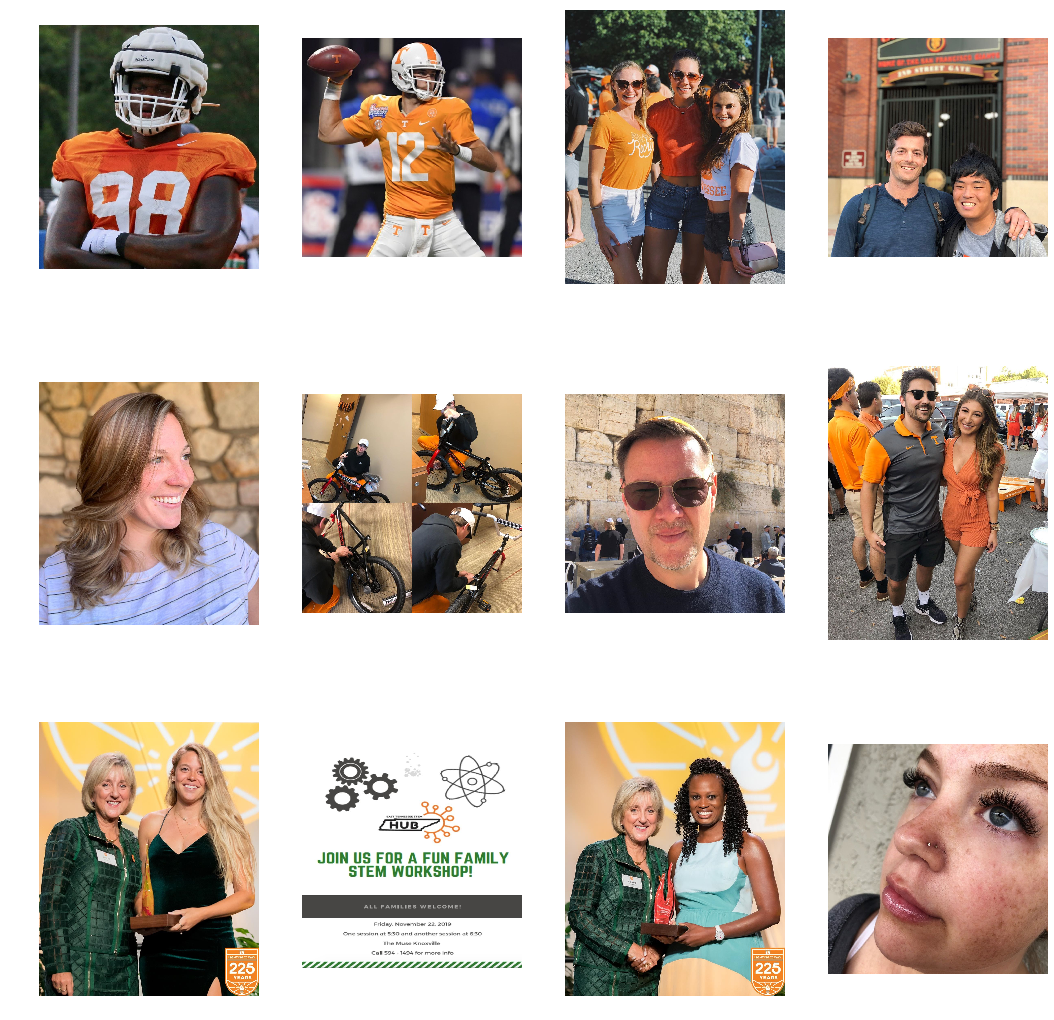

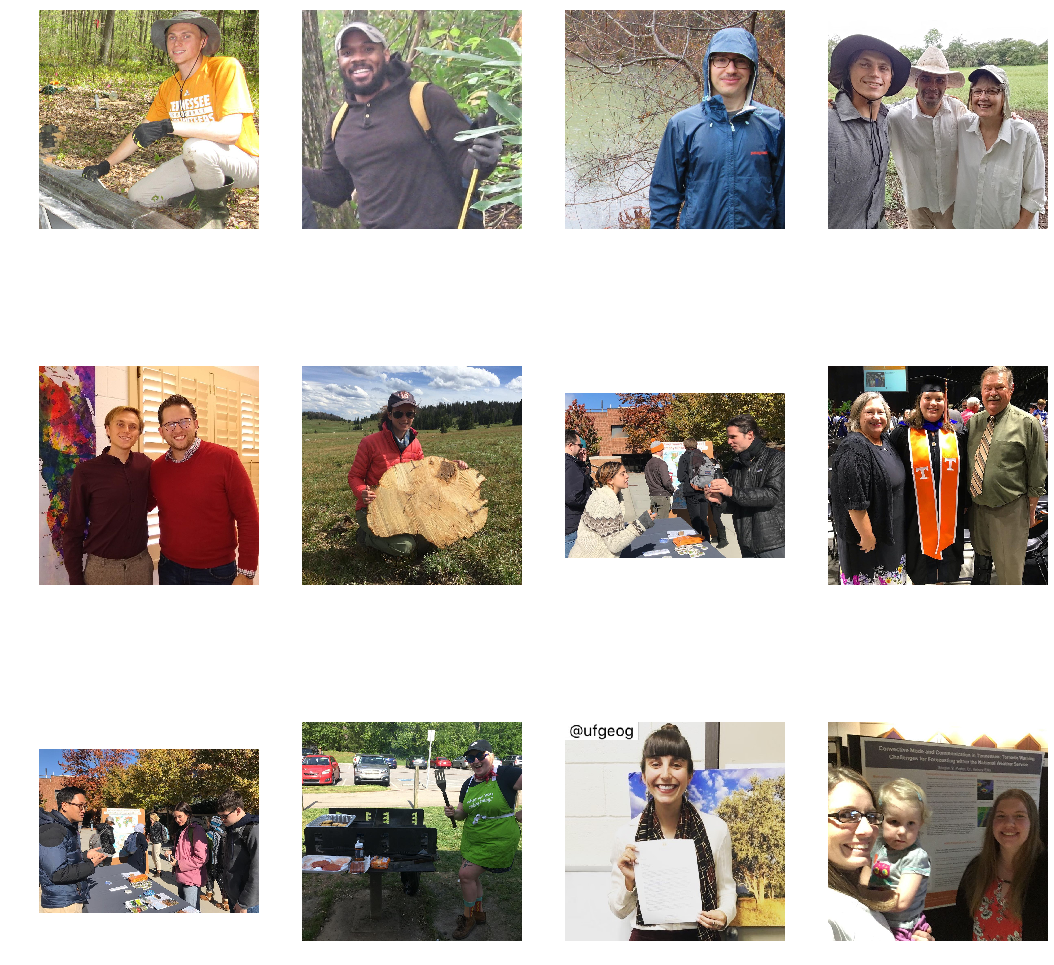

In [17]:
list = pd.DataFrame(collections.Counter(comm_vgg19[:, 1, 1]).most_common(10), columns=["Category", "Count"])
list2 = [list["Category"][i] for i in range(len(list))]

['stage',
 'limousine',
 'tow_truck',
 'racer',
 'minivan',
 'scoreboard',
 'web_site',
 'police_van',
 'minibus',
 'buckle']

In [9]:
if keras_flag:
    vgg_fc2 = Model(inputs=vgg19_full.input, outputs=vgg19_full.get_layer('fc2').output)
    y = vgg_fc2.predict(comm_img)
    print(y.shape)
else:
    print((1, 4096))

(80, 4096)


In [10]:
process_new = True

if process_new:
    comm_fc2 = vgg_fc2.predict(comm_img, verbose=True)
    print(comm_fc2.shape)

80/80 [==============================] - 8s 103ms/step
(80, 4096)


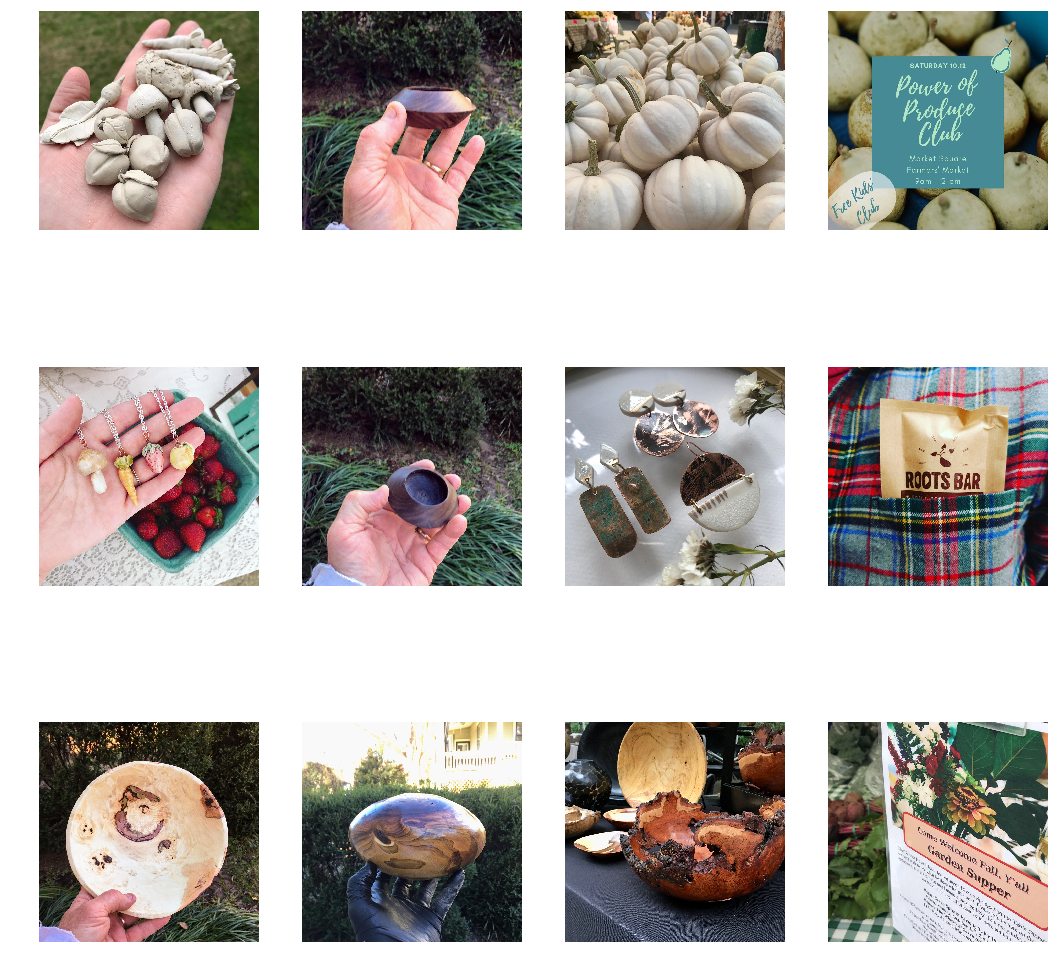

In [11]:
plt.figure(figsize=(14, 14))

dists = np.sum(np.abs(comm_fc2 - comm_fc2[1, :]), 1)
idx = np.argsort(dists.flatten())[:12]

for ind, i in enumerate(idx):
    try:
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.subplot(3, 4, ind + 1)

        img = imread(files.iloc[i]["Filepaths"])
        plt.imshow(img)
        plt.axis("off")
    except:
        pass